In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fetchGHCNStationData(stationId):
    """Returns a DataFrame with record max temp, record min temp,
    average max temp, and average min temp
    from the 1991-2020 period from the provided GHCNd Station Id
    """

    # Reads a GHCNd csv file at selected Station Id from AWS S3 Bucket.
    df = pd.read_csv(
        f"http://noaa-ghcn-pds.s3.amazonaws.com/csv/by_station/{stationId}.csv"
    )

    # Select date, element, and data value columns and select the 1991-2020 period.
    df = df[["DATE", "ELEMENT", "DATA_VALUE"]]
    df = df[(df["DATE"] >= 19910101) & (df["DATE"] <= 20201231)]
    df = df[df["ELEMENT"].isin(["TMAX", "TMIN"])]
    df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d")

    # Create pivot table from Element column and convert data to degrees Celcius.
    pivot = df.pivot(index="DATE", columns="ELEMENT", values="DATA_VALUE").reset_index()
    pivot["TMAX"] = pivot["TMAX"] / 10
    pivot["TMIN"] = pivot["TMIN"] / 10
    pivot["md"] = pivot["DATE"].dt.strftime("%m-%d")

    # Compute record max temp, record min temp, average max temp, and average min temp
    dailyagg = pivot.groupby(["md"], as_index=False).agg(
        record_max_temp=("TMAX", "max"),
        record_min_temp=("TMIN", "min"),
        average_max_temp=("TMAX", "mean"),
        average_min_temp=("TMIN", "mean"),
    )

    return pivot, dailyagg

In [3]:
# Get Asheville, NC Airport Station Id and call the fetch function.
avl_stid = "USW00003812"
df, agg = fetchGHCNStationData(avl_stid)
df

/var/folders/8t/4dcpfx6j29d858grh_vp_d_m0000gn/T/ipykernel_92128/1540462304.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


ELEMENT,DATE,TMAX,TMIN,md
0,1991-01-01,5.0,-3.9,01-01
1,1991-01-02,13.9,2.2,01-02
2,1991-01-03,6.1,2.2,01-03
3,1991-01-04,7.8,3.9,01-04
4,1991-01-05,8.9,3.3,01-05
...,...,...,...,...
10953,2020-12-27,10.6,-6.6,12-27
10954,2020-12-28,11.1,-1.0,12-28
10955,2020-12-29,13.9,2.8,12-29
10956,2020-12-30,4.4,1.7,12-30


In [4]:
agg

,md,record_max_temp,record_min_temp,average_max_temp,average_min_temp
0,01-01,19.4,-11.7,10.083333,-1.400000
1,01-02,19.4,-13.2,9.016667,-0.806667
2,01-03,22.8,-12.2,8.410000,-1.306667
3,01-04,21.7,-11.1,9.426667,-1.670000
4,01-05,19.4,-12.2,9.073333,-1.653333
...,...,...,...,...,...
361,12-27,21.7,-8.9,10.300000,-1.433333
362,12-28,19.4,-9.4,10.130000,-0.766667
363,12-29,21.7,-8.3,11.466667,0.190000
364,12-30,20.0,-8.9,9.620000,-1.226667


In [5]:
# Select a year from the Asheville Airport data
df = df[(df["DATE"] >= "2016-01-01") & (df["DATE"] <= "2016-12-31")]

# Compute range of record, average, and actual max and min temperatures.
record_range = agg["record_max_temp"] - agg["record_min_temp"]
average_range = agg["average_max_temp"] - agg["average_min_temp"]
actual_range = df["TMAX"] - df["TMIN"]

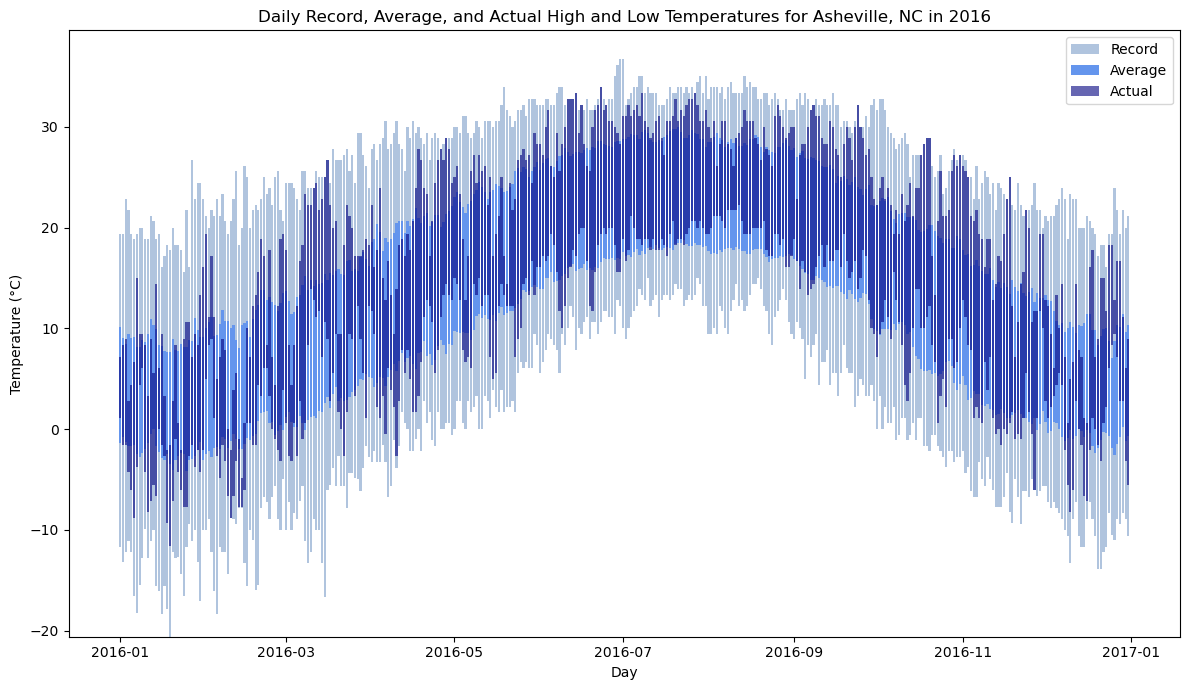

In [6]:
# Plot record, average, and actual max and min temperatures.
plt.figure(figsize=(12, 7))

plt.bar(
    df["DATE"],
    record_range,
    bottom=agg["record_min_temp"],
    color="lightsteelblue",
    label="Record",
)

plt.bar(
    df["DATE"],
    average_range,
    bottom=agg["average_min_temp"],
    color="cornflowerblue",
    label="Average",
)

plt.bar(
    df["DATE"], actual_range, bottom=df["TMIN"], color="navy", label="Actual", alpha=0.6
)

plt.ylabel("Temperature (°C)")
plt.xlabel("Day")
plt.title(
    "Daily Record, Average, and Actual High and Low Temperatures for Asheville, NC in 2016"
)
plt.legend()
plt.tight_layout()

plt.show()